
# 📊 SaaS Revenue Project — Analytics, Forecasting & Exec Insights

**Flow:**  
Step 1 → Data Cleaning & Prep  
Step 2 → Revenue Trends  
Step 3 → Customer Dynamics  
Step 4 → Cohorts  
Step 5 → Segmentation  
Step 6 → ARPU & LTV  
Step 7 → Churn & Expansion  
Step 8 → Forecast (ARIMA)  
Step 9 → BusinessInsights  


In [1]:

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

DATA_DIR = Path("../data")
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
VIS_DIR = Path("./visuals")
REPORTS_DIR = Path("./reports")

for d in [PROCESSED_DIR, VIS_DIR, REPORTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)



## Step 1 → Data Cleaning & Preparation



In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
customers_path = "../data/raw/saas_customers.csv"
transactions_path = "../data/raw/saas_transactions.csv"
mrr_path = "../data/raw/saas_mrr_aggregated.csv"


customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)
mrr_df = pd.read_csv(mrr_path)

#Cleaned column names
def clean_cols(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

customers_df = clean_cols(customers_df)
transactions_df = clean_cols(transactions_df)
mrr_df = clean_cols(mrr_df)

#Renamed customerid to customer_id 
def rename_customer_id(df):
    for col in df.columns:
        if col.lower().replace(" ", "") == "customerid":
            df.rename(columns={col: "customer_id"}, inplace=True)
            break
    return df

customers_df = rename_customer_id(customers_df)
transactions_df = rename_customer_id(transactions_df)

#Converted date columns to datetime
customers_df['signup_date'] = pd.to_datetime(customers_df['signup_date'], errors='coerce')
customers_df['churn_date'] = pd.to_datetime(customers_df['churn_date'], errors='coerce')

transactions_df['date'] = pd.to_datetime(transactions_df['date'], errors='coerce')
mrr_df['date'] = pd.to_datetime(mrr_df['date'], errors='coerce')

#Merged transactions and customers on customer_id (left join)
trans_cust_df = transactions_df.merge(customers_df, on="customer_id", how="left")

print("Merged transactions + customers shape:", trans_cust_df.shape)
print("MRR aggregate shape:", mrr_df.shape)

print("\nSample of trans_cust_df:")
print(trans_cust_df.head())

print("\nSample of mrr_df:")
print(mrr_df.head())

cols_to_drop = [col for col in trans_cust_df.columns if col.endswith('_x')]
trans_cust_df = trans_cust_df.drop(columns=cols_to_drop)

trans_cust_df = trans_cust_df.rename(columns=lambda x: x.rstrip('_y'))

print(trans_cust_df.columns.tolist())


Merged transactions + customers shape: (54126, 13)
MRR aggregate shape: (44, 6)

Sample of trans_cust_df:
  customer_id       date    mrr plan_x region_x acquisition_channel_x  is_churn_month signup_date churn_date plan_y  \
0     C000001 2022-01-01  52.69    SMB     APAC                Social           False  2022-01-01 2022-04-01    SMB   
1     C000001 2022-02-01  75.12    SMB     APAC                Social           False  2022-01-01 2022-04-01    SMB   
2     C000001 2022-03-01  53.16    SMB     APAC                Social           False  2022-01-01 2022-04-01    SMB   
3     C000001 2022-04-01  51.76    SMB     APAC                Social            True  2022-01-01 2022-04-01    SMB   
4     C000002 2022-01-01  56.27    SMB       EU               Organic           False  2022-01-01 2022-07-01    SMB   

  region_y acquisition_channel_y  base_mrr  
0     APAC                Social      52.2  
1     APAC                Social      52.2  
2     APAC                Social      52.2  


## Step 2 → Revenue Trends


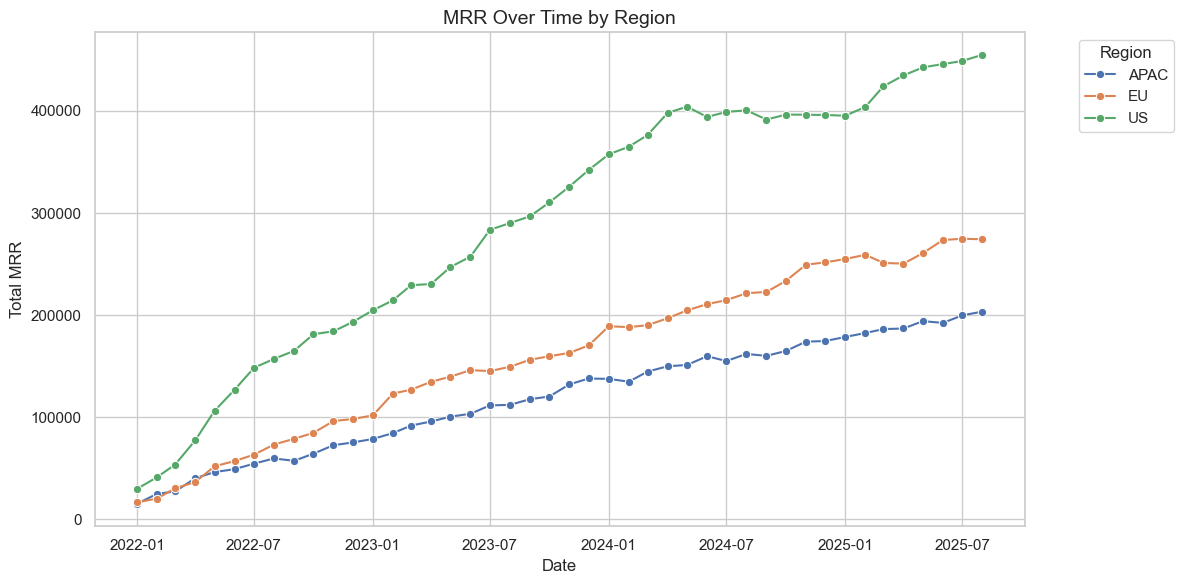

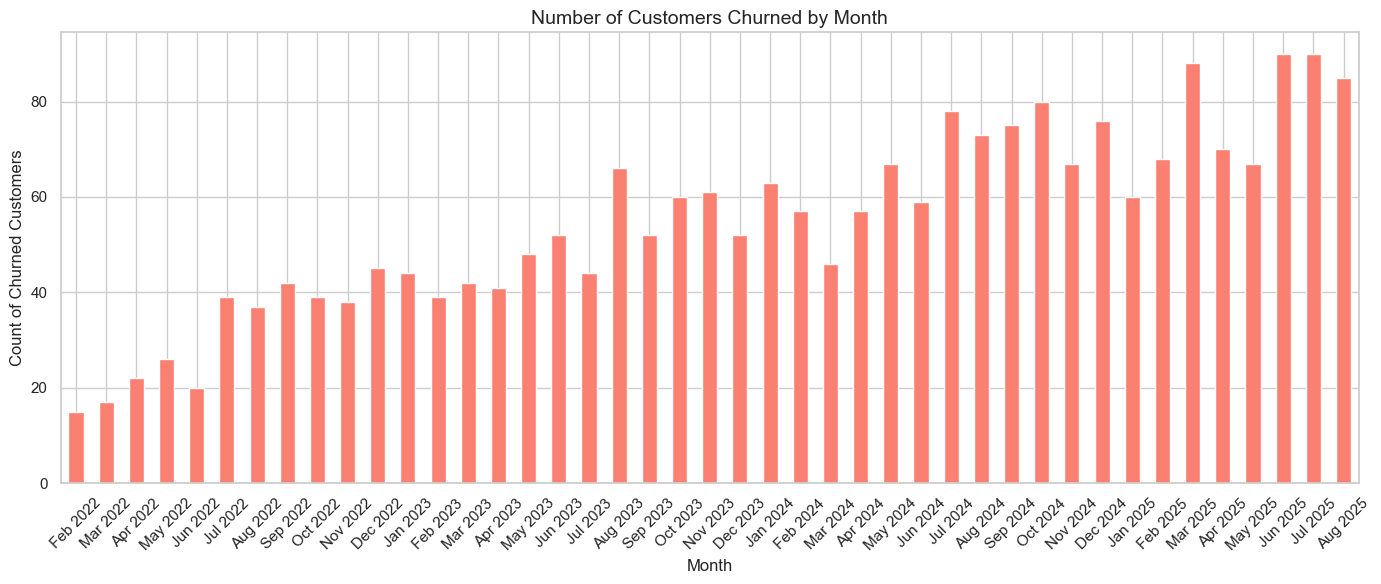

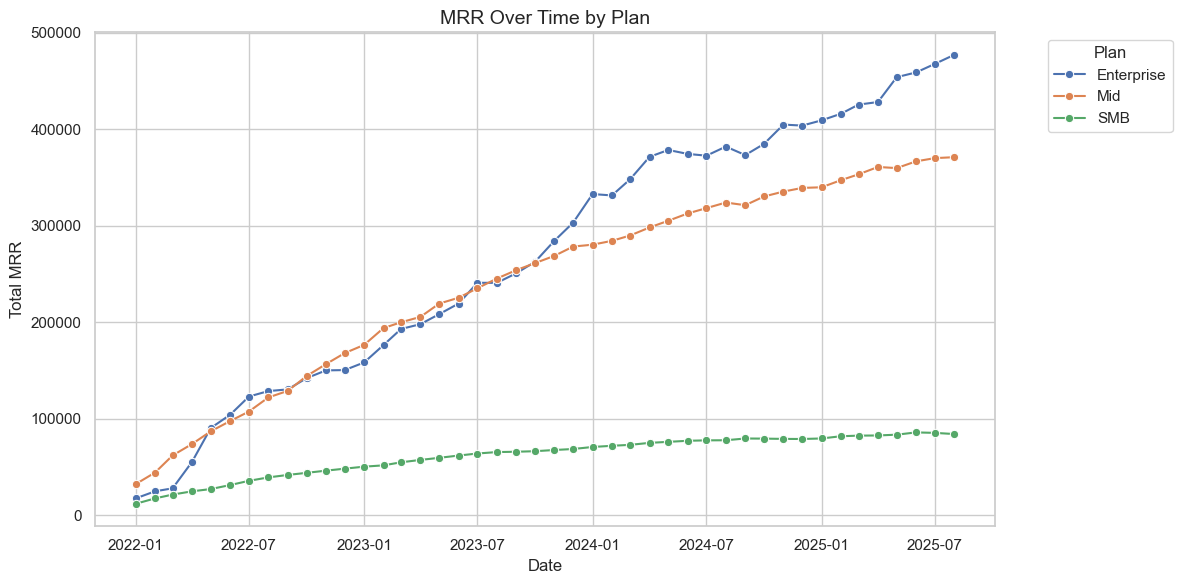

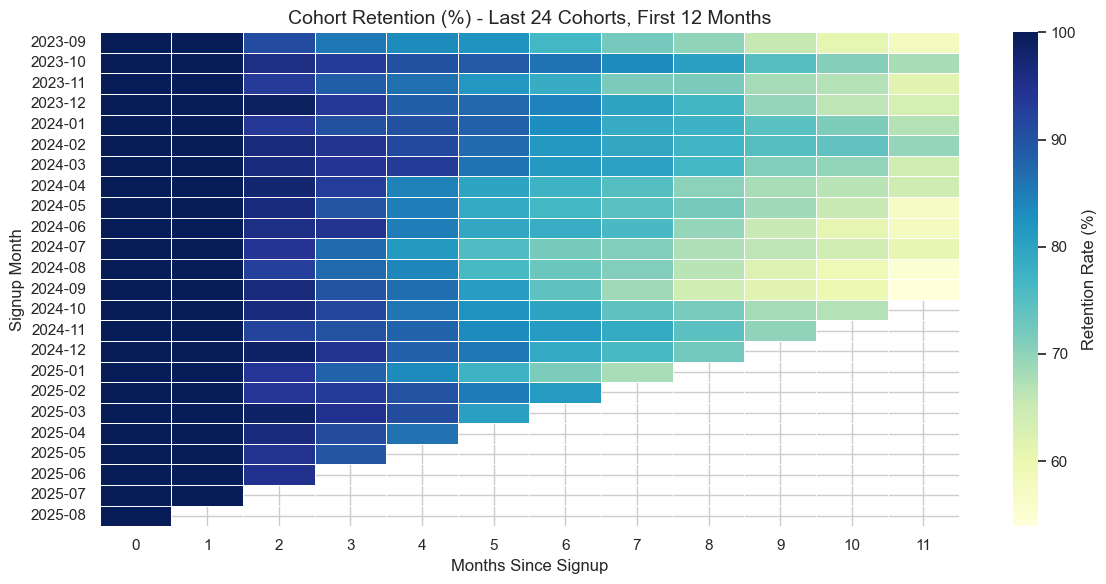

/var/folders/mq/lcc6b5yd4n9_f3f080j3bvwc0000gn/T/ipykernel_13345/3789395623.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mrr_acq_channel.index, y=mrr_acq_channel.values, palette='muted')


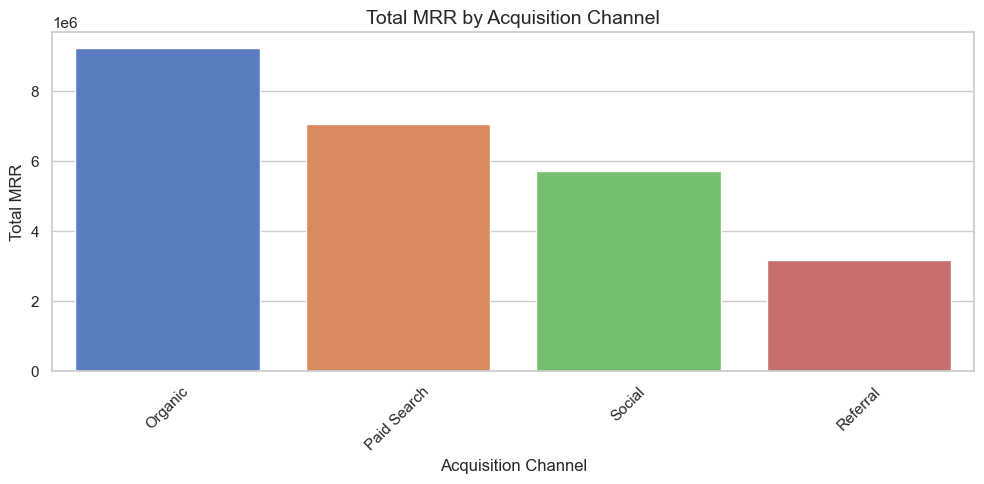

In [3]:
# EDA visualized

# Setting consistent visual style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# MRR Over Time by Region
mrr_region_time = trans_cust_df.groupby(['date', 'region'])['mrr'].sum().reset_index()

plt.figure()
sns.lineplot(data=mrr_region_time, x='date', y='mrr', hue='region', marker='o')
plt.title("MRR Over Time by Region")
plt.xlabel("Date")
plt.ylabel("Total MRR")
plt.legend(title='Region', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()   # ✅ Works in notebooks

# ---X---- #

# Churn Pattern
churn_by_month = trans_cust_df[trans_cust_df['is_churn_month']].groupby('date')['customer_id'].nunique()
churn_by_month.index = churn_by_month.index.to_period('M').strftime('%b %Y')

plt.figure(figsize=(14,6))
churn_by_month.plot(kind='bar', color='salmon')
plt.title("Number of Customers Churned by Month")
plt.xlabel("Month")
plt.ylabel("Count of Churned Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---X---- #

# MRR Over Time by Plan
mrr_plan_time = trans_cust_df.groupby(['date', 'plan'])['mrr'].sum().reset_index()

plt.figure()
sns.lineplot(data=mrr_plan_time, x='date', y='mrr', hue='plan', marker='o')
plt.title("MRR Over Time by Plan")
plt.xlabel("Date")
plt.ylabel("Total MRR")
plt.legend(title='Plan', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

# ---X---- #

# Cohort Analysis (Active Customers)
trans_cust_df['signup_month'] = trans_cust_df['signup_date'].dt.to_period('M')
trans_cust_df['transaction_month'] = trans_cust_df['date'].dt.to_period('M')
trans_cust_df['months_since_signup'] = (
    trans_cust_df['transaction_month'] - trans_cust_df['signup_month']
).apply(lambda x: x.n)

cohort_data = trans_cust_df.groupby(['signup_month', 'months_since_signup'])['customer_id'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='signup_month', columns='months_since_signup', values='customer_id')
cohort_retention = cohort_counts.divide(cohort_counts.iloc[:,0], axis=0) * 100

plt.figure(figsize=(12,6))
sns.heatmap(
    cohort_retention.tail(24).iloc[:, :12],
    cmap='YlGnBu',
    cbar_kws={'label':'Retention Rate (%)'},
    annot=False,
    linewidths=0.5
)
plt.title("Cohort Retention (%) - Last 24 Cohorts, First 12 Months")
plt.xlabel("Months Since Signup")
plt.ylabel("Signup Month")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ---X---- #

# MRR by Acquisition Channel
mrr_acq_channel = trans_cust_df.groupby('acquisition_channel')['mrr'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=mrr_acq_channel.index, y=mrr_acq_channel.values, palette='muted')
plt.title("Total MRR by Acquisition Channel")
plt.xlabel("Acquisition Channel")
plt.ylabel("Total MRR")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




## Step 3 → Customer Dynamics


<Figure size 1200x600 with 0 Axes>

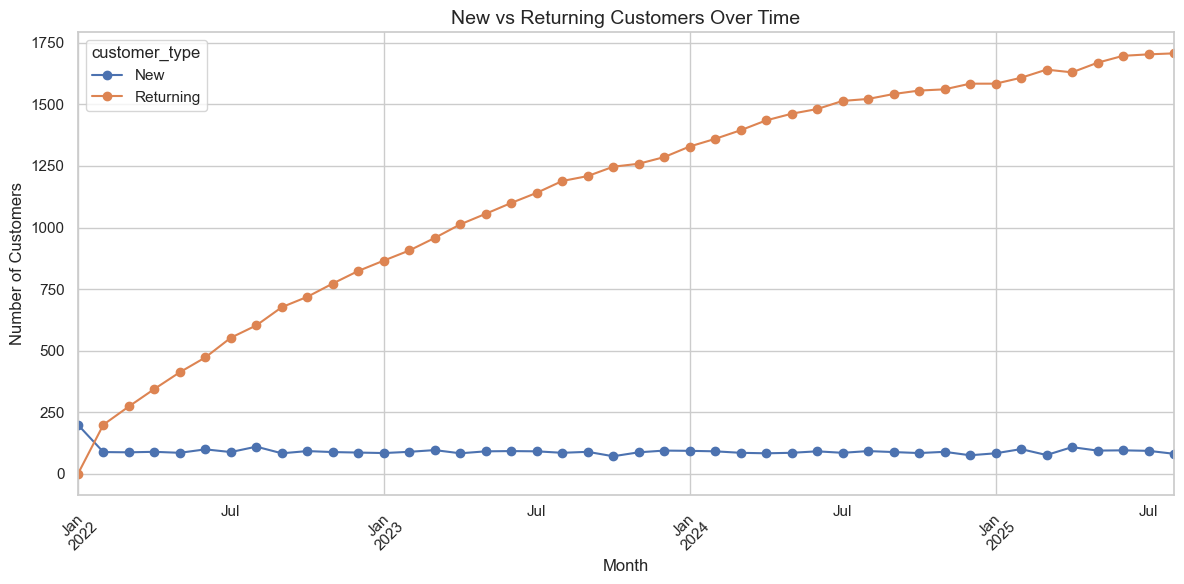

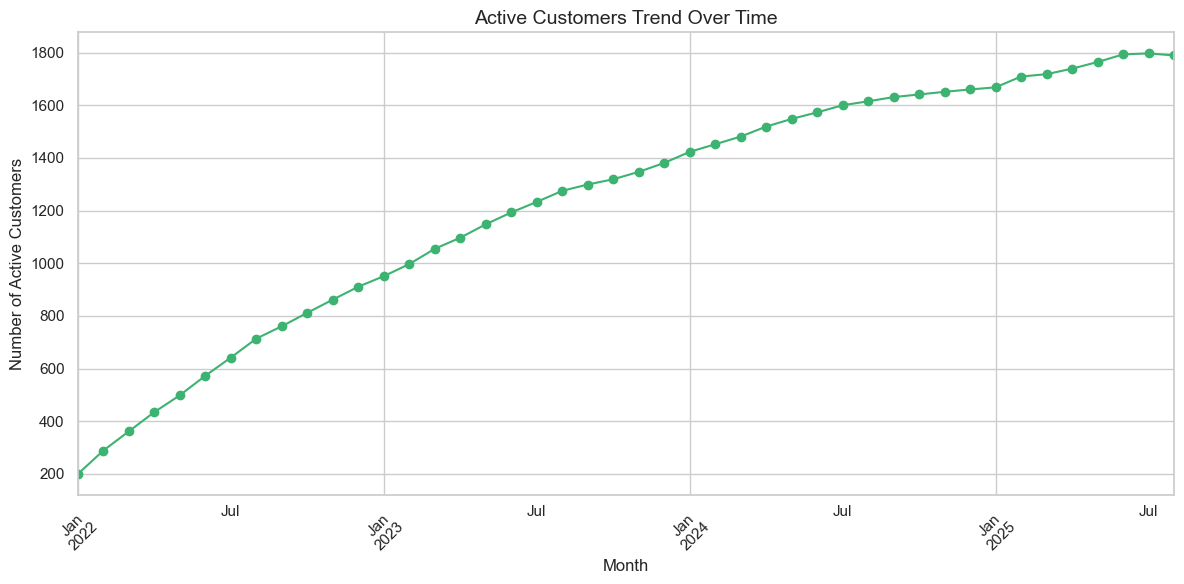

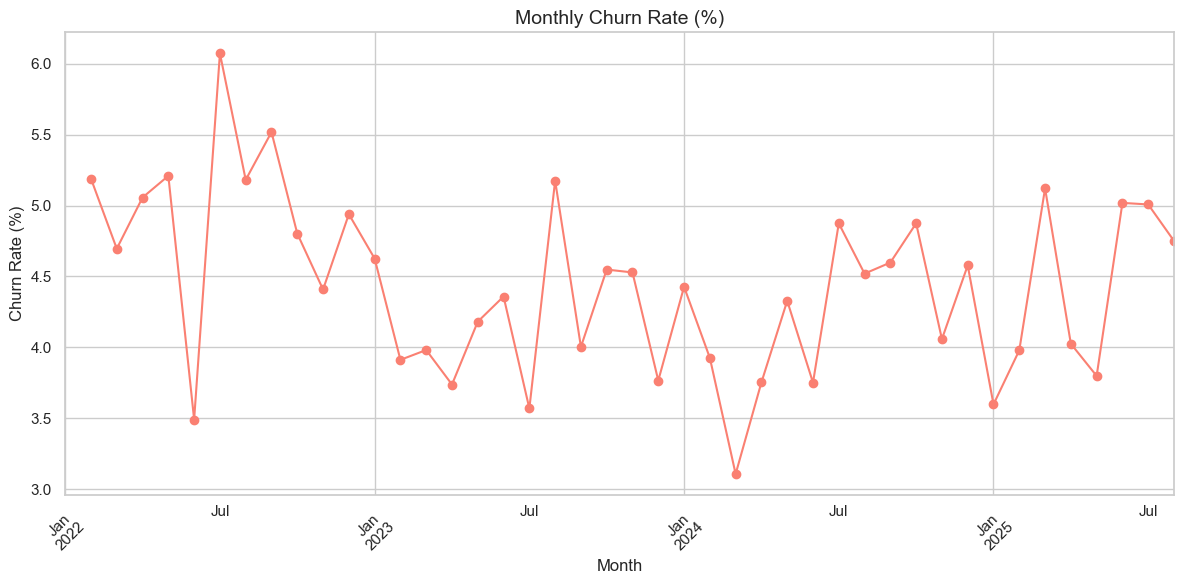

In [4]:


# Customer Dynamics

# New vs Returning Customers 
# Ensure transaction_month is in period format
trans_cust_df['transaction_month'] = trans_cust_df['date'].dt.to_period('M')

# Identify first transaction month per customer
first_txn = trans_cust_df.groupby('customer_id')['transaction_month'].min().reset_index()
first_txn.columns = ['customer_id', 'first_transaction_month']

# Merged back to main df
trans_cust_df = trans_cust_df.merge(first_txn, on='customer_id', how='left')

# Flaged new vs returning
trans_cust_df['customer_type'] = trans_cust_df.apply(
    lambda x: 'New' if x['transaction_month'] == x['first_transaction_month'] else 'Returning', axis=1
)

# Count per month
customer_counts = trans_cust_df.groupby(['transaction_month', 'customer_type'])['customer_id'].nunique().reset_index()

# Pivot for plotting
customer_counts_pivot = customer_counts.pivot(index='transaction_month', columns='customer_type', values='customer_id').fillna(0)

# Plot
plt.figure(figsize=(12,6))
customer_counts_pivot.plot(kind='line', marker='o')
plt.title("New vs Returning Customers Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Active customers per month
active_customers = trans_cust_df.groupby('transaction_month')['customer_id'].nunique()

plt.figure(figsize=(12,6))
active_customers.plot(kind='line', marker='o', color='mediumseagreen')
plt.title("Active Customers Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Active Customers")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Churned Customers Trend
# Churn rate = churned customers / active customers
churn_by_month = trans_cust_df[trans_cust_df['is_churn_month']].groupby('transaction_month')['customer_id'].nunique()
churn_rate = (churn_by_month / active_customers) * 100

plt.figure(figsize=(12,6))
churn_rate.plot(kind='line', marker='o', color='salmon')
plt.title("Monthly Churn Rate (%)")
plt.xlabel("Month")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Step 4 → Cohorts (Extended)


In [5]:

# Extended cohort KPIs
cohort_size = cohort_counts.iloc[:, 0].rename("cohort_size").to_frame()
display_cols = [c for c in cohort_retention.columns if c in [1,3,6,12]]
cohort_ret_summary = cohort_retention[display_cols] if display_cols else cohort_retention.iloc[:, :4]
cohort_kpi = cohort_size.join(cohort_ret_summary, how='left')
cohort_kpi.head()


,cohort_size,1,3,6,12
signup_month,,,,,
2022-01,200.0,100.0,87.500000,73.000000,51.500000
2022-02,89.0,100.0,86.516854,75.280899,57.303371
2022-03,88.0,100.0,86.363636,75.000000,56.818182
2022-04,90.0,100.0,88.888889,65.555556,43.333333
2022-05,86.0,100.0,93.023256,83.720930,62.790698



## Step 5 → Segmentation


/var/folders/mq/lcc6b5yd4n9_f3f080j3bvwc0000gn/T/ipykernel_13345/971539542.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_region.index, y=revenue_region.values, palette="viridis")


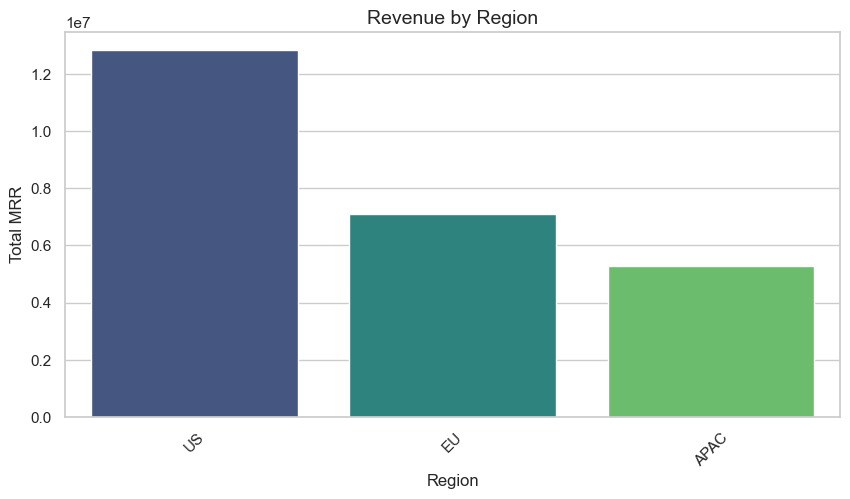

/var/folders/mq/lcc6b5yd4n9_f3f080j3bvwc0000gn/T/ipykernel_13345/971539542.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_plan.index, y=revenue_plan.values, palette="mako")


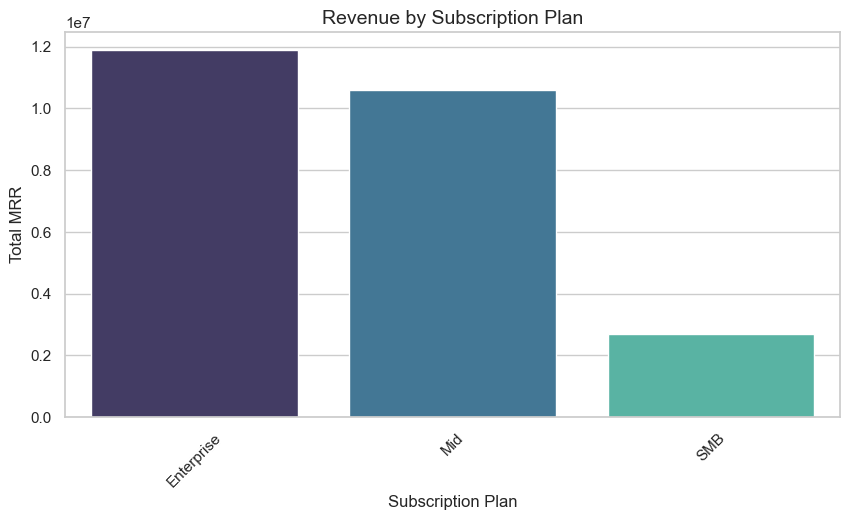

In [6]:


# Revenue by Region
revenue_region = trans_cust_df.groupby('region')['mrr'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=revenue_region.index, y=revenue_region.values, palette="viridis")
plt.title("Revenue by Region")
plt.ylabel("Total MRR")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.show()

# Revenue by Subscription Plan
revenue_plan = trans_cust_df.groupby('plan')['mrr'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=revenue_plan.index, y=revenue_plan.values, palette="mako")
plt.title("Revenue by Subscription Plan")
plt.ylabel("Total MRR")
plt.xlabel("Subscription Plan")
plt.xticks(rotation=45)
plt.show()


## Step 6 → ARPU & LTV


/var/folders/mq/lcc6b5yd4n9_f3f080j3bvwc0000gn/T/ipykernel_13345/3372884270.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  active_by_month_exact = trans_cust_df.groupby('date')['customer_id'].nunique().reindex(total_mrr_by_month.index).fillna(method='ffill')


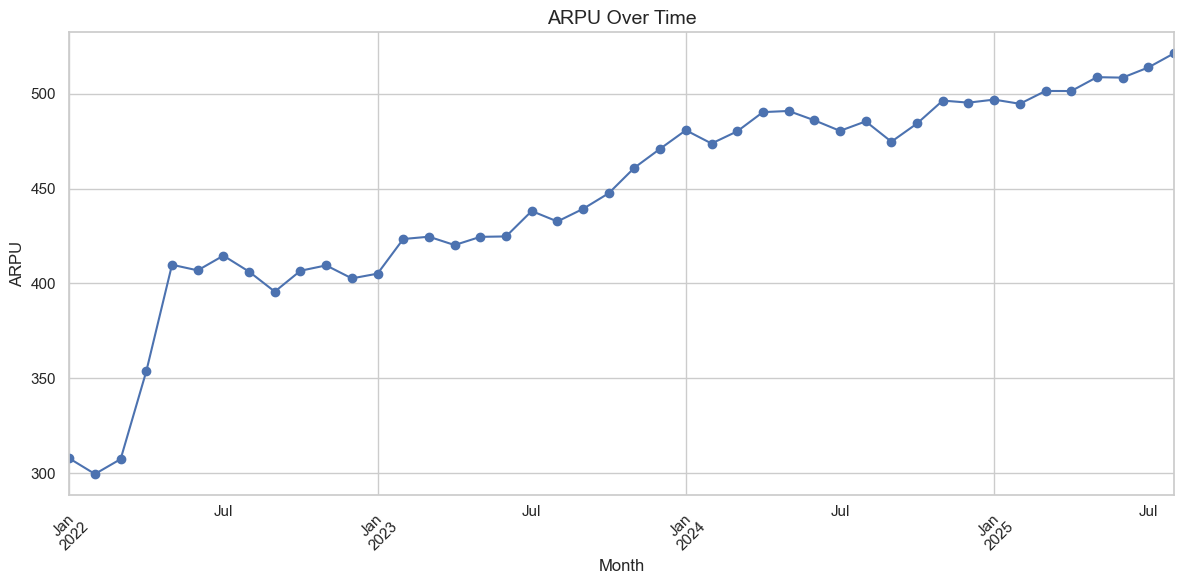

Average ARPU: 445.47
Estimated Average Customer Lifespan (months): 10.70
Estimated LTV: 4765.51


In [7]:

# ARPU Trend
total_mrr_by_month = mrr_df.groupby('date')['mrr'].sum().sort_index()
active_by_month_exact = trans_cust_df.groupby('date')['customer_id'].nunique().reindex(total_mrr_by_month.index).fillna(method='ffill')
monthly_arpu = total_mrr_by_month / active_by_month_exact.replace(0, np.nan)

plt.figure(figsize=(12,6))
monthly_arpu.plot(marker='o')
plt.title("ARPU Over Time")
plt.xlabel("Month")
plt.ylabel("ARPU")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Approximate LTV
avg_customer_lifespan_days = (customers_df['churn_date'] - customers_df['signup_date']).dt.days.dropna()
avg_customer_lifespan_months = (avg_customer_lifespan_days.mean() / 30) if len(avg_customer_lifespan_days) > 0 else np.nan
avg_arpu = monthly_arpu.mean()
ltv_estimate = avg_arpu * avg_customer_lifespan_months if pd.notnull(avg_customer_lifespan_months) else np.nan

print(f'Average ARPU: {avg_arpu:.2f}')
print(f'Estimated Average Customer Lifespan (months): {avg_customer_lifespan_months:.2f}')
print(f'Estimated LTV: {ltv_estimate:.2f}')



## Step 7 → Churn & Expansion


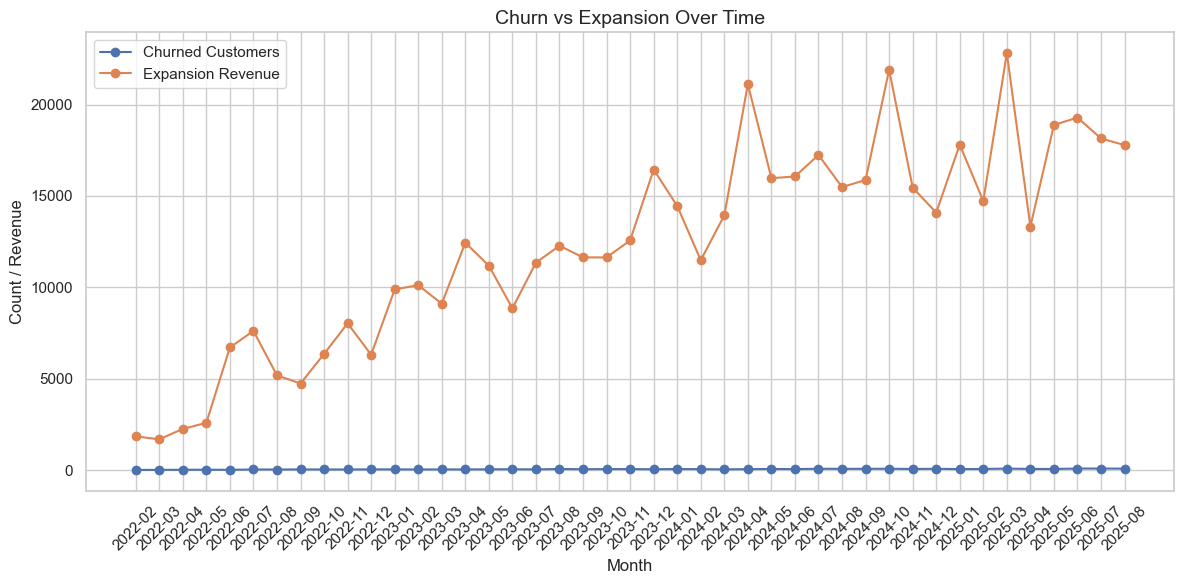

In [8]:

# Churned customers per month
churn_by_txn_month = trans_cust_df[trans_cust_df['is_churn_month']].groupby('transaction_month')['customer_id'].nunique()

# Expansion revenue (positive MRR deltas month-over-month per customer)
mrr_by_cust_month = trans_cust_df.groupby(['transaction_month','customer_id'])['mrr'].sum().sort_index()
expansion = mrr_by_cust_month.groupby('customer_id').diff()
expansion = expansion[expansion > 0].groupby(level=0).sum()

plt.figure(figsize=(12,6))
plt.plot(churn_by_txn_month.index.astype(str), churn_by_txn_month.values, marker='o', label="Churned Customers")
plt.plot(expansion.index.astype(str), expansion.values, marker='o', label="Expansion Revenue")
plt.title("Churn vs Expansion Over Time")
plt.xlabel("Month")
plt.ylabel("Count / Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Step 8 → Forecast (ARIMA)


Best ARIMA order: None | Test RMSE: inf


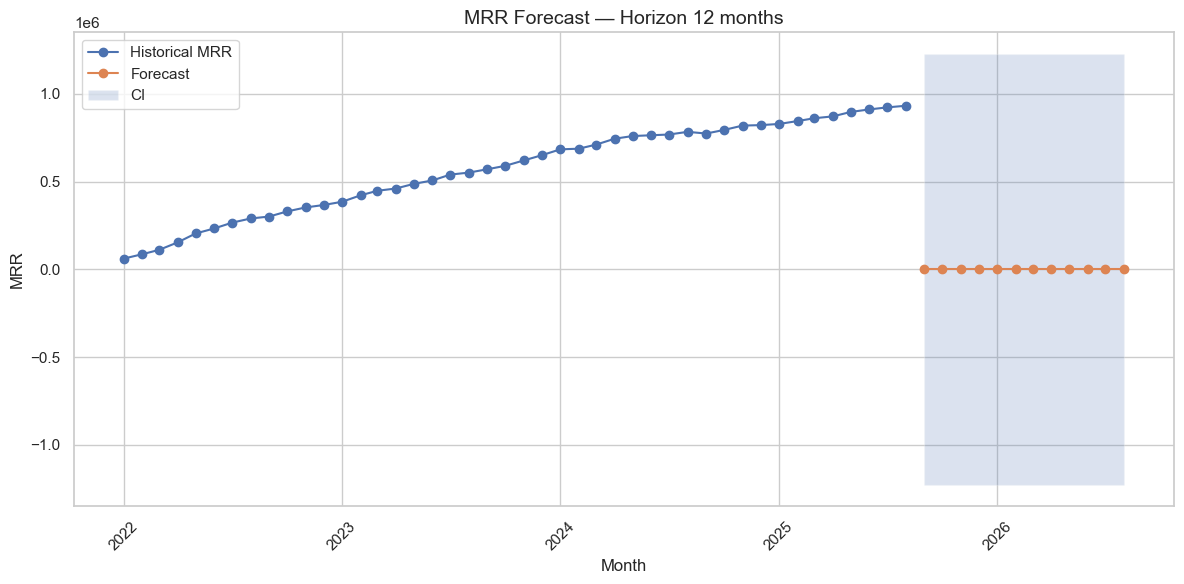

Saved: ../data/processed/mrr_forecast.csv


In [9]:

# Monthly MRR series
ts = mrr_df.groupby('date')['mrr'].sum().sort_index()
ts = ts.asfreq('MS').interpolate()  # ensure monthly continuity

# Train/Test split
h = min(6, max(1, int(len(ts)*0.15)))
train, test = ts.iloc[:-h], ts.iloc[-h:]

def fit_sarimax(order, y):
    model = SARIMAX(y, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    return res

orders = [(p,d,q) for p in [0,1,2] for d in [0,1] for q in [0,1,2]]
best_order, best_rmse, best_res = None, np.inf, None

for order in orders:
    try:
        res = fit_sarimax(order, train)
        pred = res.get_forecast(steps=len(test)).predicted_mean
        rmse = mean_squared_error(test, pred, squared=False)
        if rmse < best_rmse:
            best_order, best_rmse, best_res = order, rmse, res
    except Exception:
        continue

print(f"Best ARIMA order: {best_order} | Test RMSE: {best_rmse:.2f}")

# Refit on full data
final_model = SARIMAX(ts, order=best_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

forecast_horizon = 12
forecast_res = final_model.get_forecast(steps=forecast_horizon)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

forecast_df = pd.DataFrame({
    "date": pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(), periods=forecast_horizon, freq='MS'),
    "mrr_forecast": forecast_mean.values,
    "lower_ci": forecast_ci.iloc[:,0].values,
    "upper_ci": forecast_ci.iloc[:,1].values
})

plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values, marker='o', label="Historical MRR")
plt.plot(forecast_df['date'], forecast_df['mrr_forecast'], marker='o', label="Forecast")
plt.fill_between(forecast_df['date'], forecast_df['lower_ci'], forecast_df['upper_ci'], alpha=0.2, label="CI")
plt.title(f"MRR Forecast — Horizon {forecast_horizon} months")
plt.xlabel("Month")
plt.ylabel("MRR")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

forecast_df.to_csv(PROCESSED_DIR / "mrr_forecast.csv", index=False)
print("Saved:", PROCESSED_DIR / "mrr_forecast.csv")



## Step 10 → Business Insights



In [10]:
import streamlit as st
import pandas as pd
from openai import OpenAI


df = mrr_df.copy()  

# Dropdown analysis options
analysis_option = st.selectbox(
    "Choose an analysis for Business Advisor:",
    ["Revenue Growth Insights", "Customer Trends", "Churn Risk"]
)

summary_text = ""

if analysis_option == "Revenue Growth Insights":
    latest = df['mrr'].iloc[-1]
    prev = df['mrr'].iloc[-2]
    growth = (latest - prev) / prev * 100
    summary_text = f"Revenue grew by {growth:.2f}% compared to last month."

elif analysis_option == "Customer Trends":
    active_customers = df['customer_id'].nunique()
    summary_text = f"You currently have {active_customers} active customers. Engagement appears steady."

elif analysis_option == "Churn Risk":
    churn_rate = df[df['status'] == 'churned']['customer_id'].nunique() / df['customer_id'].nunique()
    summary_text = f"Current churn risk is estimated at {churn_rate:.2%}. Consider focusing on retention strategies."

# Show summary text
st.subheader(" Business Advisor")
st.write(summary_text)


2025-08-23 15:55:09.107 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 15:55:09.107 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 15:55:09.108 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 15:55:09.108 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 15:55:09.108 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-08-23 15:55:09.109 WARNING streamlit.runtime.scriptrunner_utils.script_run_c